# Pipe3 : 
## To classify location of damage - front, rear or side

In [1]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter 
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [40]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l2, l1

In [15]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [6]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, ', val_accuracy:', model_hist['val_accuracy'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

In [7]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout();
    
    print("Best Model:")
    print_best_model_results(hist)

In [32]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3))
    train_labels = to_categorical(train_labels)
    
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    validation_labels=np.append(validation_labels, 1)
    validation_labels=np.append(validation_labels, 1)
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
        
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model,fit.history

In [41]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    optimizer = SGD(learning_rate=1e-4, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history

In [50]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    
    pred_labels = [np.argmax(pred) for pred in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

## Image dataset details

In [43]:
location = 'D:/Dataset/New/data3a/P3'
loc='D:/Dataset/New/data3a'
top_model_weights_path = location+'/top_model.weights.h5'
fine_tuned_model_path = location+'/ft_model.keras'
model1 = location+'/bottleneck_fc_model.h5'
train_data_dir = loc+'/t'
validation_data_dir = loc+'/v'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

img_width, img_height = 256,256
epochs = 50
batch_size = 16

In [16]:
save_bottleneck_features()

Found 1383 images belonging to 3 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step
Found 248 images belonging to 3 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 997ms/step


In [33]:
d3_model, d3_history = train_categorical_model()

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.4259 - loss: 6.0482 - val_accuracy: 0.5685 - val_loss: 1.0090
Epoch 2/50
 3/87 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5174 - loss: 1.0170

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5082 - loss: 1.3110 - val_accuracy: 0.6048 - val_loss: 0.8023
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6152 - loss: 0.9072 - val_accuracy: 0.6411 - val_loss: 0.7990
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6301 - loss: 0.8501 - val_accuracy: 0.4556 - val_loss: 1.1209
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6474 - loss: 0.7876 - val_accuracy: 0.6411 - val_loss: 0.7463
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6675 - loss: 0.7421 - val_accuracy: 0.6855 - val_loss: 0.7187
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6623 - loss: 0.7379 - val_accuracy: 0.6653 - val_loss: 0.7453
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7150 - loss: 0.6239 - val_accuracy: 0.6250 - val_loss: 0.9583
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7054 - loss: 0.7412 - val_accuracy: 0.6492 - val_loss: 0.

Best Model:
epoch: 6 , val_accuracy: 0.6854838728904724 , val_loss: 0.7187134027481079


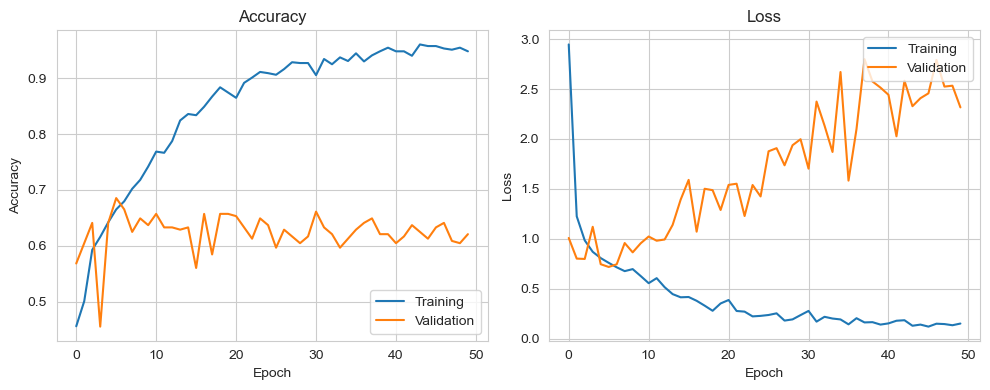

In [35]:
plot_metrics(d3_history)

In [44]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.
Epoch 1/50


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3354 - loss: 1.3167
Epoch 1: val_accuracy improved from -inf to 0.36250, saving model to D:/Dataset/New/data3a/P3/ft_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3356 - loss: 1.3165 - val_accuracy: 0.3625 - val_loss: 1.1433
Epoch 2/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.3750 - loss: 1.4142

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.36250 to 0.50000, saving model to D:/Dataset/New/data3a/P3/ft_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3750 - loss: 0.7153 - val_accuracy: 0.5000 - val_loss: 0.5979
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3387 - loss: 1.3005
Epoch 3: val_accuracy did not improve from 0.50000
86/86 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.3388 - loss: 1.3006 - val_accuracy: 0.3542 - val_loss: 1.1525
Epoch 4/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.3125 - loss: 1.3853
Epoch 4: val_accuracy improved from 0.50000 to 0.75000, saving model to D:/Dataset/New/data3a/P3/ft_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3125 - loss: 0.7007 - val_accuracy: 0.7500 - val_loss: 0.4590
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3530 - loss: 1.2963
Epoch 5: val_accuracy did not improve from 0.75000
86/86 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3528 - loss: 1.2967 

In [46]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [51]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 248 images belonging to 3 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 980ms/step

              precision    recall  f1-score   support

           0       0.29      0.17      0.22        82
           1       0.25      0.17      0.20        75
           2       0.43      0.70      0.54        91

    accuracy                           0.37       248
   macro avg       0.32      0.35      0.32       248
weighted avg       0.33      0.37      0.33       248




## Pipe3.1

In [63]:
def pipe31(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

In [67]:
pipe31(r'C:\Users\chara\OneDrive\Desktop\k1.jpeg', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Validating location of damage....Result: Side
Severity assessment complete.


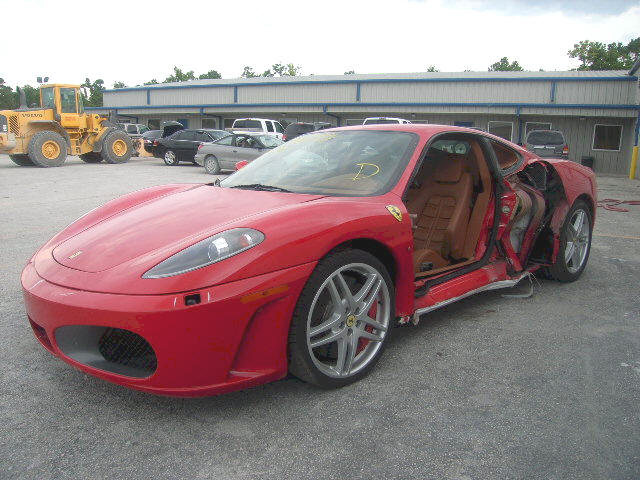

In [56]:
Image('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')

In [68]:
pipe31('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Validating location of damage....Result: Side
Severity assessment complete.
